Le Guillouzic Maël / Kodakov Ivan

# Rapport Projet IMA 201 : Détection de la grille d'origine JPEG à partir du nombre de zéros de la DCT et son utilisation pour la falsification d'images

### 1. Introduction

Dans le processus de création et d’enregistrement d’une image, les données brutes qui sortent du capteur sont amenées à subir diverses opérations : réduction du bruit, dématriçage, ajustement des couleurs, correction gamma, compression, etc... Ces opérations laissent des traces dans l’image finale, souvent invisibles à l’œil nu mais détectables statistiquement. En détectant et interprétant ces traces, on peut retracer partiellement l’historique de l’image, comprendre les opérations effectuées lors de sa création, leur ordre et leurs paramètres. Des anomalies dans ces traces peuvent indiquer des falsifications d’images.

C’est notamment à l’une de ces opérations que nous nous intéressons dans ce travail : **la compression JPEG**. Une méthode appelée "a contrario", va nous permettre de repérer des grilles principales ou secondaires et les utiliser pour obtenir des informations sur l’image. Cette méthode ne s’appuie uniquement sur la valeur des pixels de l’image et en aucun cas sur les métadonnées de cette dernière.

*Les objectifs sont les suivants :*
- *Détecter la présence d’une grille principale, qui nous permettra de savoir si l’image a été compressée par le passé au format JPEG, et si elle a été redimensionnée par exemple.*
- *Détecter la présence de grilles secondaires, qui peuvent traduire notamment une falsification de notre image.*

### 2. L’aspect théorique : la compression JPEG

Les meilleurs taux de compressions en JPEG sont obtenus lorsque l’image est convertie du format **RGB** au format **YCbCr** (Luminance/Chrominance). Or nous remarquons que notre code est déjà suffisamment complexe en ne prenant en compte que la luminance de chaque image, et nous verrons que cela nous donne des résultats amplement suffisants. On ne prendra donc pas en compte les canaux **Cb** et **Cr** de nos images.

La conversion JPEG réalise ensuite un sous-échantillonnage de cette Luminance.

Puis, vient l’étape importante qui nous servira de fondement à nos travaux. On découpe l’image en petits carrés de 8 pixels par 8 pixels. Ce sont sur ces *blocs élémentaires* que l’on va réaliser les opérations de compression. On utilisera cette propriété dans la suite du projet.

Puis on applique une **DCT (Discrete Cosine Transform)** à tous nos blocs 8x8 de l’image. Cette opération est une variante de la transformée de Fourier et décompose un bloc de pixels en une somme de fonctions cosinus oscillants à diverses fréquences. Chaque bloc est ainsi décrit en une carte de fréquences et en amplitudes plutôt qu’en pixels et coefficients de couleur. La valeur d’une fréquence reflète l’importance et la rapidité d’un changement, tandis que la valeur d’une amplitude correspond à l’écart associé à chaque changement de couleur.

La transformée DCT s’exprime mathématiquement par :

$$
DCT(i, j) = \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} C(i)C(j) \cdot pixel(x, y) \cdot \cos\left(\frac{xi}{N}\cdot \frac{2\pi}{N}\right) \cdot \cos\left(\frac{yj}{N}\cdot \frac{2\pi}{N}\right)
$$

Et la constante vaut :

$$
C(x) = 
\begin{cases} 
\frac{1}{\sqrt{2}} & \text{si} \, x = 0 \\
1 & \text{sinon}
\end{cases}
$$

![DCT](zzimg/DCT.png)

**Quantification**: Ensuite, on passe à la quantification qui est l’étape où la compression se produit réellement, étape qui permet de gagner de la place mais qui en conséquent fait perdre de l’information. On va pour cela partir de chaque bloc 8x8 retourné par la DCT et diviser cette matrice par une autre que l’on appelle matrice de quantification. Nous ne rentrerons pas dans le détail du calcul de cette matrice, mais à la suite de cette opération de nombreux coefficients sont proches de zéro. Il suffit alors d’appliquer un seuillage (mettre à zéro tout pixel qui est en dessous du seuil). On obtient alors une matrice remplie de zéros et de quelques coefficients non nuls. En écrivant le résultat compressé par un codage de type Huffman, il est alors possible de gagner énormément de place.

![Quantization](zzimg/quantization.png)

Si on a pris le temps de détailler les bases de la compression JPEG, c’est parce que l’on va fortement exploiter les propriétés techniques de cette méthode dans notre projet.


### 3. Détection de la grille d'origine

Cette section décrit le principe de base de notre projet, coder une méthode qui nous permette de détecter la grille d'origine d'une image compressée en JPEG par le passé (cette dernière n’a plus besoin de l’être) et nous la retourner.

Pour cela, nous allons utiliser uniquement la composante luminance de chaque image comme nous l'avons vu précédemment. Une étape importante est alors de déterminer quels sont les coefficients de la DCT qui étaient nuls lors de la compression. En effet, lors de la décompression, une DCT inverse est effectuée sur chaque bloc et une image non compressée est obtenue. Mais les coefficients réels en sortie de la DCT sont parfois arrondis pour pouvoir être affichés par nos écrans, et lorsque l’on recompresse on n’aura pas forcément 0 tout pile. Pour cela, on mettra un seuil à 0,5. Tout coefficient qui est inférieur à 0,5 sera considéré comme nul et donc remplacé par 0.

La prochaine étape est de déterminer la carte à l'origine de notre compression JPEG. En effet, lorsque l'on a compressé une première fois, il a fallu prendre une origine pour toutes nos grilles 8x8 qui se juxtaposent alors les unes aux autres à partir de cette origine. Le plus souvent, on prend (0, 0) comme origine, mais si l'image est ensuite rognée ou collée sur une autre image, ce n'est plus le cas. On va donc rechercher **cette grille d'origine avec la méthode suivante**.

Chaque pixel peut appartenir à 64 blocs 8x8 différents et superposés. On va calculer pour chaque pixel le DCT des 64 blocs auxquels il peut appartenir, et obtenir ainsi le nombre de zéros correspondants. Ainsi, on considérera que le bloc qui obtient le plus de zéros correspond à la compression la plus *probable* qui a pu avoir lieu. Le pixel va alors voter pour ce bloc en question. En répétant cette opération sur tous les pixels de l'image, on va alors obtenir une carte des votes de chaque pixel. On formulera les hypothèses suivantes pour cette carte :

- Le vote pour un bloc en particulier se fait en votant pour son pixel le plus en haut à gauche possible (son origine en somme).
- Ce vote sera stocké sous forme d'un entier entre 0 et 64 correspondant aux pixels de la grille la plus en haut à gauche de l'image. Dans les faits, voter pour un bloc au milieu de l'image revient à voter pour une grille dont l'origine se trouve dans le bloc 8x8 tout en haut à gauche de l'image.
- Si deux blocs ont le même nombre de zéros, le pixel correspondant ne vote pas (-1 dans la carte de vote).
- Les bordures de l'image sur une largeur de 7 pixels ne votent pas. En effet, les pixels situés au sein de ces bordures n'appartiennent pas à 64 blocs mais à moins, et leur vote ne serait donc pas équitable.

![8x8](zzimg/8x8grids.png)

*Remarque* : En réalité, ce processus de calcul est extrêmement coûteux en temps et en ressources. On utilise une astuce détaillée plus loin pour minimiser les temps de calcul.


### 4. Validation Statistique

Lors de l’analyse d’une image JPEG, la grille la plus votée correspond probablement à la bonne. Cependant, rien ne garantit que cette grille ne soit beaucoup plus votée que les autres, elle peut l’être par une toute petite marge et n’avoir donc pas grand sens en tant que grille principale. Un critère statistique est donc nécessaire pour décider si cette prédominance est causée par la compression JPEG ou non.

On va donc utiliser un indicateur appelé **NFA**, qui prend appui sur l’hypothèse d’un modèle nul stochastique. En d'autres termes, on va calculer un NFA qui correspond à la probabilité qu'une grille soit votée si tout est aléatoire. Si on est au-dessus d'un seuil, c'est que notre mesure n'est pas suffisamment sûre et on va donc la rejeter. Inversement, plus cette valeur est petite et plus il est probable que la relation ait une interprétation causale.

Sans détailler plus que ça la manière dont on calcule ce NFA, on aura ainsi a priori :

$$
P(K \geq k) = B(n, k, p) = \sum_{j=k}^{n} \binom{n}{j} p^j(1 - p)^{n - j}
$$

Par ailleurs il nous faut prendre en compte d'autres paramètres :
- La multiplicité des tests. En effet même si les chances d'obtenir une grille aléatoirement sont faibles, sur plusieurs centaines de milliers de test cette propabilité augmente. On va donc effectuer une correction de Bonferroni en ajoutant un terme .
- Prendre en compte le fait que les votes sont réalisés dans une fenetre de taille 8x8.

In fine, on définit le **NFA** :

$$
NFA(g, w) = NT \cdot B\left(\frac{|w|}{64}, \frac{v}{64}, \frac{1}{64}\right)
$$

où :

- $|w|$ est le nombre total de pixels dans la fenêtre $w$,
- $v$ est le nombre total de votes pour $g$ dans $w$,
- $NT$ est la multiplicité des tests.

On calculera donc ce NFA pour toutes les fenêtres de l'image. Si ce dernier est supérieur à un seuil $\epsilon$ que l’on fixera, alors le vote est considéré comme n'étant pas suffisamment fiable et le pixel est marqué comme non-votant. On fixe dans notre cas le seuil à $\epsilon = 1$.

### 5. Améliorations

#### 5.1 Blocs Constants
Lorsqu’une image présente des surfaces plutôt floues, cela a tendance, lors de la compression JPEG, à transformer des blocs entiers en blocs unis. En effet, lorsqu'elle est fortement compressée, la zone floue est quantifiée, et un grand nombre des blocs de 8x8 qui étaient presque plats deviennent plats. Or les régions qui sont constantes selon l’axe X ou Y nous posent problème pour la validation statistique, puisque pour un pixel donné, ce ne sont plus 64 mais beaucoup moins de blocs qui sont différents. Le test statistique pourrait être trompé en considérant comme significatives des configurations qui ne le sont pas. Dans des conditions aléatoires, il s’agirait d’un accident extrêmement rare ; cependant, la tendance du JPEG à créer des blocs constants le long de la direction verticale ou horizontale nécessite de gérer cette situation. Pour cela, on va empêcher les blocs qui vérifient cette propriété de voter, comme on le fait déjà pour les égalités.

#### 5.2 Détection de Falsifications
Jusqu’à présent, notre méthode détecte la grille principale de chaque image. Mais si l’on part du principe que la majorité des images manipulées sont passées par un format JPEG un jour ou l'autre, alors si on réalise un montage avec plusieurs images, on devrait pouvoir repérer des grilles différentes. Ainsi, on analyse chaque région avec une grille significative différente de celle principale, ce qui laisse présager une contrefaçon, puisque l'image copiée-collée conserve des traces de sa grille d'origine. Dans 63 cas sur 64 (si les deux grilles ne s'alignent pas par malchance ou si la retouche n'est pas faite volontairement pour brouiller les pistes), on pourra détecter cette région de l'image.

## II. Pratique
### 6. Prérequis
La première étape consiste en l'importation des librairies nécessaires à notre projet.

In [1]:
import numpy as np
import platform
import tempfile
import os
import math
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import io, color
from scipy.fftpack import dct
from scipy.stats import binom
from scipy.fft import dct
import cv2
from PIL import Image

Ensuite nous importons les images à analyser grâce à io. Nous avons enregistré de
nombreuses images sur lequelles nous avons travaillés tout au long de ce projet dans le
dossier /zzimg. Ce dossier est disponible sur notre Github à l'adresse 

In [2]:
pelican=io.imread('zzimg/pelican99.jpg')
peliccan = color.rgb2ycbcr(pelican)

pelicancrop=io.imread('zzimg/pelican99crop.jpg')
pelicancrop = color.rgb2ycbcr(pelicancrop)

pelicanmontage = io.imread('zzimg/pelicanmontage.jpg', as_gray=False)
pelicanmontage = color.rgb2ycbcr(pelicanmontage)

pelicanmodified = io.imread('zzimg/tampered2_99.jpg')
pelicanmodified = color.rgb2ycbcr(pelicanmodified)

On réalise une fonction pour calculer le NFA d'une grille. Pour cela il est nécessaire de définir la fonction BinTail qui calcule la somme des probabilités binomiales de 1 à $k-1$, somme qu'on va soustraire à 1 pour obtenir la queue de notre probabilité binomiale de $k$ à $n$. Ensuite on calcule le NFA à l'aide des dimensions de l'image.

In [3]:
def BinTail(n, k, p):
    return 1 - binom.cdf(k - 1, n, p)

def NFA(nvotes, X, Y):  # on lui donne en entrée le nombre de votes pour la grille de détection, et les dimensions de l'image
    p = 1 / 64
    n = (X * Y) / 64
    nvotes2 = nvotes / 64
    # Remarque : on pourrait calculer nvotes directement à l'intérieur de cette fonction
    result = ((X * Y * 64) ** 2) * BinTail(n, nvotes2, p)
    # print("NFA result : {:.20}".format(result))
    return result

On introduit ensuite la fonction voteMAP. Cette fonction retourne comme on l'a vu plus haut une carte de la même taille que l'image, et contenant pour chaque pixel son vote pour une des 64 grilles possibles. Pour cela on utilise une petite astuce pour réduire le temps de calcul. Au lieu de balayer chaque pixel de l'image, et de calculer les 64 blocs possibles on procède différemment.

On balaye chaque bloc de 64 cases de l'image, et pour chaque bloc on réalise la DCT afin d'obtenir le nombre de zéros. Puis on compare pour chaque pixel de ce bloc si le nombre de zéros par rapports aux blocs précédents. En d'autres termes, si le pixel à déja vu passer un bloc avec un plus grand nombre de zéros, on ne fait rien, mais si c'est le bloc actuel qui semble etre optimal alors :
- on conserve ce nombre maximal de zéros rencontré
- on conserve les coordonnées de la grille qui correspond à cet optimum
Ceci permet ainsi de diminuer grandement les calculs. On oublie pas à la fin de classifier les bordures de l'image comme non-votant comme il a été précisé plus haut.


In [4]:
def voteMAP(image):  # image en luminance
    shape = image.shape
    X = shape[0]
    Y = shape[1]
    votes = np.zeros((X, Y))  # Table des votes
    zeros = np.zeros((X, Y))  # Table des zeros
    # DCT par blocs de 8x8 pixels
    counter = 0
    for x in range(X - 7):
        for y in range(Y - 7):
            counter += 1
            # print(f"Bloc n°{counter}")
            z = 0  # Nombre de zeros dans le bloc
            bloc = image[x:x + 8, y:y + 8, 0]
            cx = True
            cy = True
            for xx in range(8):
                for yy in range(8):
                    # print(f"bloc[{xx},{yy}] = {bloc[xx,yy]}")
                    if bloc[xx, yy] != bloc[xx, 0] and yy != 0:  # On verifie que le bloc n'est pas constant selon x
                        cx = False
                    if bloc[xx, yy] != bloc[0, yy] and xx != 0:  # idem pour y
                        cy = False

            # print(f"cx = {cx}, cy = {cy}")
            dctblock = dct(dct(bloc.T, norm='ortho').T, norm='ortho')  # DCT du bloc
            for xx in range(8):
                for yy in range(8):
                    if abs(dctblock[xx, yy]) < 0.5:
                        z += 1  # On compte les zeros

            for xx in range(x, x + 8):  # On vote pour le bloc
                for yy in range(y, y + 8):
                    if z > 0 and z >= zeros[xx, yy]:
                        if cx or cy:
                            votes[xx, yy] = -1
                        elif z == zeros[xx, yy]:
                            votes[xx, yy] = -1
                        else:
                            zeros[xx, yy] = z
                            votes[xx, yy] = (x % 8 + y % 8 * 8)  # On vote pour la meilleure grille
                            # print(f"Vote pour {votes[xx,yy]} aux coordonnées [{xx},{yy}]")
                            # print(f'Nombre de zeros : {z} dans le bloc [{x},{y}] et vote pour {votes[xx,yy]}')

    # On elimine les bordures de l'image
    for xx in range(X):
        for yy in range(7):
            votes[xx, yy] = -1
        for yy in range(Y - 7, Y):
            votes[xx, yy] = -1
    for yy in range(Y):
        for xx in range(7):
            votes[xx, yy] = -1
        for xx in range(X - 7, X):
            votes[xx, yy] = -1

    print(f"Nombre de blocs traitées dans voteMAP: {counter}")
    print("voteMAP terminé")
    return votes

La fonction imcolor permets d'afficher une carte des votes plus visuelles, chaque vote correspond à une couleur différente. Ainsi les pixels de même couleur votent pour une même grille. Nous avons remarqué au cours de notre projet, qu'en visualisant directement la carte des votes nous avions déja la possibilité de voir en couleur ce que nous souhaitions (chaque pixel ayant un entier comme vote). Néanmoins visualiser de cette manière les images permet parfois de ne pas distinguer les détails, 2 couleurs pouvant être proches. La fonction imcolor permet ainsi de faire ressortir ces détails comme nous pouvons le voir plus loin.

In [5]:
def imcolor(image):
    X = image.shape[0]
    Y = image.shape[1]
    color_map = np.random.randint(0, 255, (8, 8), dtype=int)
    vote_map = voteMAP(image)
    new_image = np.zeros((X, Y), dtype=int)
    
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            vote = vote_map[x, y]
            if vote == -1:
                new_image[x, y] = 0  # les bords et les pixels à -1 sont mis en noir
            else:
                colorm = color_map[np.unravel_index(int(vote), (8, 8))]
                new_image[x, y] = colorm
                
    return new_image

Après avoir obtenu, la carte des votes (ou voteMap) nous pouvons ainsi rechercher le
grillage le plus voté. Il s'agit donc du grillage utilisé pour la compression jpg. C'est la
fonction detectgrid qui se charge de cette mission.

In [6]:
def detectgrid(im):  # le but de la fonction est de detecter la grille la plus presente dans l'image et de la renvoyer
    shape = im.shape
    X = shape[0]
    Y = shape[1]
    votes = voteMAP(im)
    gridvotes = np.zeros((8, 8))
    maxvote = 0
    mostvotedgrid = (0, 0)
    
    for x in range(X):
        for y in range(Y):
            if isinstance(int(votes[x, y]), int):
                if int(votes[x, y]) != -1:
                    gridvotes[np.unravel_index(int(votes[x, y]), (8, 8))] += 1
                    if gridvotes[np.unravel_index(int(votes[x, y]), (8, 8))] > maxvote:
                        maxvote = gridvotes[np.unravel_index(int(votes[x, y]), (8, 8))]
                        mostvotedgrid = np.unravel_index(int(votes[x, y]), (8, 8))
    
    NFAv = NFA(maxvote, X, Y)
    if NFAv < 1:
        print("La grille la plus presente dans l'image est la grille de coordonnees : ", mostvotedgrid, " avec ", maxvote, " votes")
        print("Le NFA de cette grille est : {:.20} ".format(NFAv))
        return mostvotedgrid  # on renvoie la grille la plus presente dans l'image sous forme de tuple (x,y) entre 0 et 7
    else:
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0, 0), 0

### 2. Mise en pratique de ces fonctions sur différents exemples
Nous souhaitons pouvoir détecter différentes opérations : le recadrage, et l'ajout d'un
élèment auparavant absent sur la photo.

#### A. Le recadrage
Si le grillage voté n'est pas associé à (0,0) alors on considère que la photo a été recadrée.
On peut aussi l'observer sur la carte de votes, dans le cas du recadrage la couleur
renvoyée sur la carte des votes est différente de l'originale.

Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
La grille la plus presente dans l'image est la grille de coordonnees :  (6, 0)  avec  182537.0  votes
Le NFA de cette grille est : 0.0 
(6, 0)
Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé


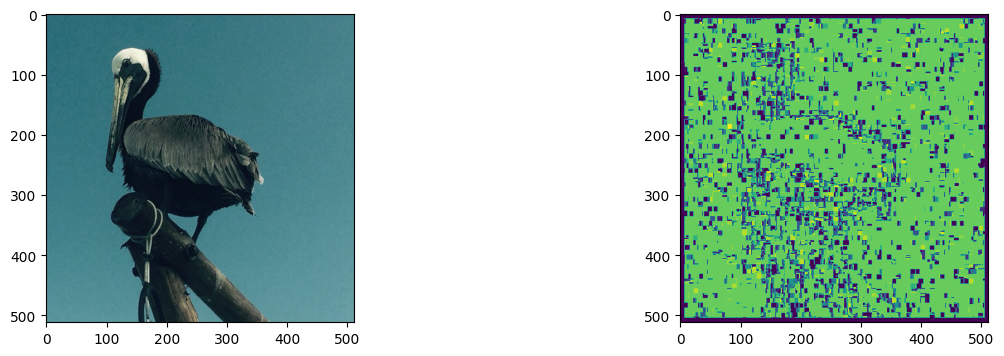

Nombre de blocs traitées dans voteMAP: 146700
voteMAP terminé
Il n'y a pas de grille dans l'image car NFA > 1
((0, 0), 0)
Nombre de blocs traitées dans voteMAP: 146700
voteMAP terminé


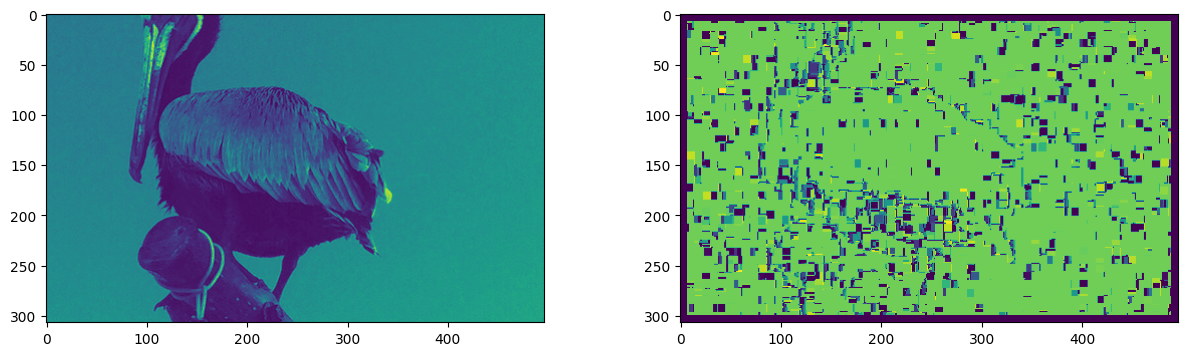

In [7]:
print(detectgrid(pelican))
fig,ax=plt.subplots(1,2,figsize=(15, 4))
ax[0].imshow(pelican)
ax[1].imshow(voteMAP(pelican))
plt.show()

print(detectgrid(pelicancrop))
fig2, ax = plt.subplots(1,2,figsize=(15,4))
ax[0].imshow(pelicancrop[:,:,0])
ax[1].imshow(voteMAP(pelicancrop))
plt.show()

On observe bien que l'image de départ et l'image recadrée n'ont pas détecté la même grille de départ. Cela est visible quand on affiche les deux voteMAP avec imcolor, deux couleurs différentes traduisent une grille de départ différentes.

#### B. L'ajout d'élément
La détection de l'ajout d'élement sur une image est remarquable par le fait que la zone concernée vote différemment des autres pixels. C'est visible sur une carte de vote, les pixels correspondants à l'élément ajouté sont de couleurs différentes.

Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé


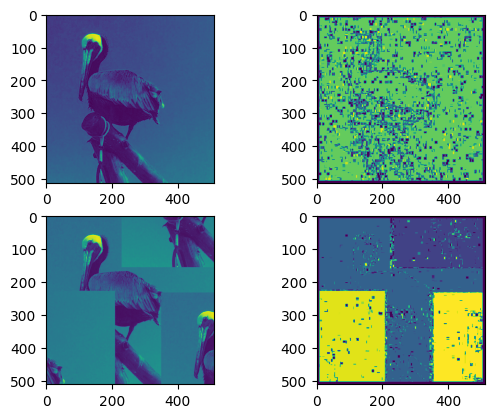

In [8]:
# Créez une grille de sous-graphiques 2x2
fig, axes = plt.subplots(2, 2)
# Affichez la première image
axes[0, 0].imshow(pelican[:,:,0])
# Affichez la deuxième image (en supposant que imcolor() modifie la couleur)
axes[0, 1].imshow(imcolor(pelican))
# Affichez la troisième image
axes[1, 0].imshow(pelicanmontage[:,:,0])
# Affichez la quatrième image
axes[1, 1].imshow(imcolor(pelicanmontage))
# Affichez la figure
plt.show()

On voit ici très clairement que l'image sur laquelle on à réalisé des collages dans tous les sens fait ressortir très clairement une carte des votes bien différente. Et encore ! L'image sur laquelle nous travaillons est compressée avec une facteur de compression $QF = 99$ ce qui est dont la compression minimale. Plus on compresse notre image et plus on verra distinctement ces collages. (voir effet compression plus loin)

#### C. Détection de falsification
Jusqu'a présent, nous sommes capable de détecter si des pixels de l'image votent pour
une grille différente. Si il y a eu modification cela est alors visible, mais nous aimerions
pouvoir faire ressortir ces modifications plus clairement. Pour cela nous avons voulu
coder une fonction `forgeries` qui pourrait nous retourner un mask avec la zone
modifiée.

L'heuristique proposée utilise une procédure de croissance de région pour partitionner la
carte de votes en régions connectées partageant le même vote de grille. En partant d'un
pixel initial (x, y), les pixels voisins votant pour la même grille sont agrégés de manière
progressive. Pour chaque région connectée dotée d'une origine de grille valide différente
de celle principale, une boîte englobante est ensuite calculée et le test statistique NFA est
effectué. Si le test statistique confirme qu'une grille étrangère est effectivement présente,
les pixels de la région connectée (qui ont tous voté pour la même grille) sont marqués
dans notre masque.

In [9]:
def forgeries(im):
    shape = im.shape
    X, Y = shape[:2]
    forgery_n = 0  # nombre de regions suspectes
    used = np.zeros((X, Y))  # tableau des pixels deja utilises
    reg_x = np.zeros((X * Y))  # tableau des coordonnees des pixels de la region
    reg_y = np.zeros((X * Y))
    votes = voteMAP(im)  # tableau des votes
    main_grid = detectgrid(im)  # grille principale
    mask = np.zeros((X, Y))  # masque des regions suspectes
    #reg_min = math.ceil(64*2*math.log(64*X*Y) / math.log(64))
    #print(reg_min)
    forged_regions = np.zeros((X*Y, 6))
    W = 6

    for x in range(7, X - 7):
        for y in range(7, Y - 7):
            if used[x, y] == 0:  # si le pixel n'a pas deja ete utilise
                if (int(votes[x, y] % 8) != main_grid[0]) or (int(votes[x, y] // 8) != main_grid[1]):  # si le pixel n'appartient pas 
                    if votes[x, y] != -1:  # si le pixel n'est pas un bord
                        reg_size = 1  # taille de la region
                        reg_x[reg_size] = x  # on ajoute le pixel à la region
                        reg_y[reg_size] = y
                        used[x, y] = 1  # on marque le pixel comme utilise
                        x0 = x  # on initialise les coordonnees de la region
                        y0 = y
                        x1 = x
                        y1 = y
                        for u in range(reg_size):  # on parcourt la region
                            for i in range(x - W, x + W):  # on parcourt les pixels autour du pixel courant
                                for j in range(y - W, y + W):
                                    if 0 <= i < X and 0 <= j < Y:  # si le pixel est dans l'image
                                        if used[i, j] == 0 and votes[i, j] == votes[x, y]:  # si le pixel n'a pas deja ete utilise
                                            reg_size += 1  # on ajoute le pixel à la region
                                            reg_x[reg_size] = i
                                            reg_y[reg_size] = j
                                            used[i, j] = 1  # on marque le pixel comme utilise
                                            x0 = min(x0, x)
                                            y0 = min(y0, y)
                                            x1 = max(x1, x)
                                            y1 = max(y1, y)

                        if reg_size > 15:  # si la region est assez grande
                            k = reg_size
                            nfa = NFA(k, x1 - x0, y1 - y0)  # on calcule le NFA de la region
                            if nfa < 1:  # si le NFA est inferieur à 1
                                forgery_n += 1  # on ajoute la region aux regions suspectes
                                forged_regions[forgery_n][0] = x0  # on enregistre les coordonnees de la region
                                forged_regions[forgery_n][1] = x1
                                forged_regions[forgery_n][2] = y0
                                forged_regions[forgery_n][3] = y1
                                forged_regions[forgery_n][4] = votes[x, y]  # on enregistre le vote de la region
                                forged_regions[forgery_n][5] = nfa  # on enregistre le NFA de la region
                                forgery_n += 1
                                for i in range(reg_size):  # on marque les pixels de la region sur le masque
                                    mask[int(reg_x[i]), int(reg_y[i])] = 255  # on marque les pixels de la region sur le masque
    kernel = np.ones((9, 9), np.uint8) * 255  # on cree un noyau pour la fermeture
    mask_final = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)  # on ferme le masque
    return mask_final


Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
La grille la plus presente dans l'image est la grille de coordonnees :  (6, 0)  avec  182537.0  votes
Le NFA de cette grille est : 0.0 


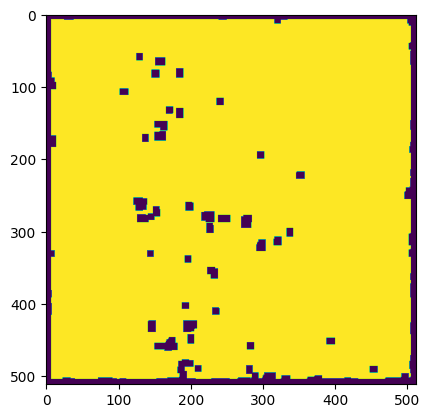

In [10]:
plt.imshow(forgeries(pelican))

Malheureusement, notre méthode ne marche pas très bien pour tous types d'images, malgré tous nos essais. Nous avons alors pensé à utiliser une fonction plus simple et qui colorait en blanc les pixels appartenant au 2e grillage le plus voté. Cependant, elle est
elle aussi très limitée dans ces applications et ne détecte pas les cas où plusieurs éléments sont introduits dans une même image

In [11]:
def detectgrid2(im):  # le but de la fonction est de detecter la grille la plus
    shape = im.shape
    X = shape[0]
    Y = shape[1]
    votes = voteMAP(im)
    gridvotes = np.zeros((8, 8))
    maxvote = 0
    maxvote2 = 0
    mostvotedgrid = (0, 0)
    mostvotedgrid2 = (0, 0)
    
    for x in range(X):
        for y in range(Y):
            if isinstance(int(votes[x, y]), int):
                if int(votes[x, y]) != -1:
                    gridvotes[np.unravel_index(int(votes[x, y]), (8, 8))] += 1
                    if gridvotes[np.unravel_index(int(votes[x, y]), (8, 8))] > maxvote:
                        maxvote = gridvotes[np.unravel_index(int(votes[x, y]), (8, 8))]
                        mostvotedgrid = np.unravel_index(int(votes[x, y]), (8, 8))
                        maxvote2 = maxvote
                        mostvotedgrid2 = mostvotedgrid
    NFAv = NFA(maxvote, X, Y)
    if NFAv < 1:
        print("La grille la plus presente dans l'image est la grille de coordonnees : ", mostvotedgrid, " avec ", maxvote, " votes")
        print("Le NFA de cette grille est : ", NFAv)
        return mostvotedgrid2  # on renvoie la grille la plus presente dans l'image sous forme de tuple (x,y) entre 0 et 7
    else:
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0, 0)

def forgeries2(im):
    shape = im.shape
    X, Y = shape[:2]
    mostvotedgrid2 = detectgrid2(im)
    votes = voteMAP(im)
    mask = np.zeros((X, Y))
    for x in range(X):
        for y in range(Y):
            if votes[x, y] != -1:
                if np.unravel_index(int(votes[x, y]), (8, 8)) == mostvotedgrid2:
                    mask[x, y] = 255
    return mask

Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
La grille la plus presente dans l'image est la grille de coordonnees :  (6, 0)  avec  216828.0  votes
Le NFA de cette grille est :  0.0
Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé


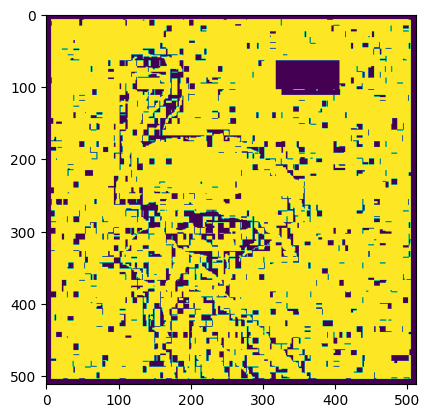

Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
La grille la plus presente dans l'image est la grille de coordonnees :  (6, 0)  avec  95465.0  votes
Le NFA de cette grille est :  0.0
Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé


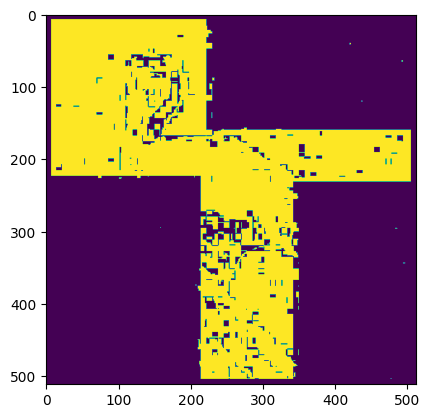

In [12]:
plt.imshow(forgeries2(pelicanmodified))
plt.show()
plt.imshow(forgeries2(pelicanmontage))
plt.show()

#### D. Visualisation de la compression sur l'efficacité de notre programme
Nous avons voulus tester notre programme sur plusieures images qui ont subies une falsification, et auxquelles on fait subir une compression de plus en plus forte. Nous utilisons pour cela une image de base : harry.jpg et avec notre programme fournit en
annexe, nous produisons plusieurs images compressées avec différents facteurs . On va alors observer deux choses :
- La silhouette de harry potter et la zone falsifiée se dégage de plus en plus du reste de l'image au fur et à mesure que le facteur de compression augmente.
- Les cotés gauche et droite se lissent de plus en plus, deviennent constant et sont donc classifiées comme non votant et colorés en violet (=noir).

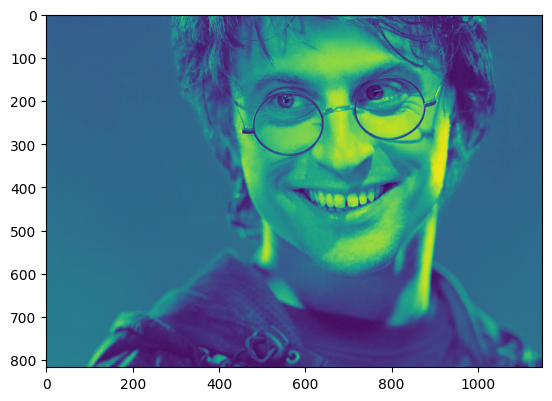

Nombre de blocs traitées dans voteMAP: 925020
voteMAP terminé


In [ ]:
harry=io.imread('zzimg/harry.jpg')
harry= color.rgb2ycbcr(harry)
plt.imshow(harry[:,:,0])
plt.show()

harry75=io.imread('zzimg/harry75.jpg')
harry75= color.rgb2ycbcr(harry75)

harry50=io.imread('zzimg/harry50.jpg')
harry50= color.rgb2ycbcr(harry50)

harry30=io.imread('zzimg/harry30.jpg')
harry30= color.rgb2ycbcr(harry30)

harry20=io.imread('zzimg/harry20.jpg')
harry20= color.rgb2ycbcr(harry20)

harry10=io.imread('zzimg/harry10.jpg')
harry10= color.rgb2ycbcr(harry10)

#print(detectgrid(harry))
#print(detectgrid(harry75))
#print(detectgrid(harry50))
#print(detectgrid(harry30))
#print(detectgrid(harry20))
#print(detectgrid(harry10))
#plt.imshow(imcolor(harry75))
#plt.imshow(imcolor(harry30))

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(imcolor(harry))
axs[1].imshow(imcolor(harry50))
axs[2].imshow(imcolor(harry20))
axs[3].imshow(imcolor(harry10))
plt.show()

### III. Annexe
Nous avons laissé en annexe quelques fonctions que nous avons utilisées au cours de
notre projet pour expérimenter, tester ou débuter notre code

In [42]:
pelican=io.imread('zzimg/pelican.jpg')
lena=io.imread('zzimg/lena5.jpg')
pelican = color.rgb2ycbcr(pelican)
lena = color.rgb2ycbcr(lena)

harry=io.imread('zzimg/harry20.jpg')
harry= color.rgb2ycbcr(harry)

pelicanm = io.imread('zzimg/pelicanmontage.jpg')
pelicanm = color.rgb2ycbcr(pelicanm)

pelicancrop = io.imread('zzimg/pelican99crop.jpg')
pelicancrop = color.rgb2ycbcr(pelicancrop)

pelican3 = io.imread('zzimg/pelicanmontage.jpg')
pelican3 = color.rgb2ycbcr(pelican3)

gaussian = io.imread('zzimg/gaussian_noise.jpg')
gaussian = color.rgb2ycbcr(cv2.cvtColor(gaussian, cv2.COLOR_BGR2RGB))

Le bloc de fonction suivant est utile pour compresser une image en python et l'enregistrer afin de travailler dessus plus tard.

In [48]:
def jpgQF(image, sortie, QF=85):
    img = Image.open(image)
    img.save(sortie, quality=QF)

image = "zzimg/pelican.jpg"
sortie = "zzimg/pelican80.jpg"
QF = 80  # Quality Factor
jpgQF(image, sortie, QF)

On utilise aussi parfois des bruits gaussiens, le bloc suivant permet d'en générer.

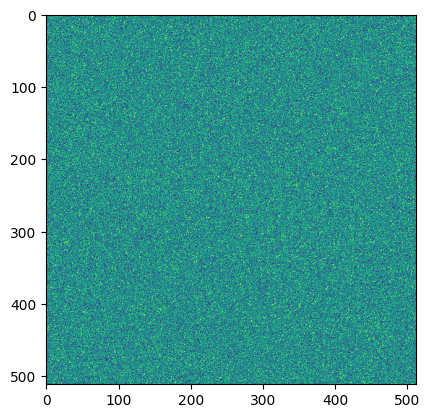

In [25]:
# Générer un bruit gaussien avec une moyenne de 128 et un écart-type de 50
mean = 128
std_dev = 50
noise = np.random.normal(mean, std_dev, (512, 512)).astype(np.uint8)

# Créer une image à partir du bruit gaussien
img = Image.fromarray(noise, mode='L') # 'L' pour une image en niveaux de gris
img.save('gaussian_noise.jpg', 'JPEG') # Enregistrer l'image en format JPEG

gaussian_noise = io.imread('gaussian_noise.jpg')
gaussian_noise = color.rgb2ycbcr(cv2.cvtColor(gaussian_noise, cv2.COLOR_BGR2RGB))
plt.imshow(gaussian_noise[:,:,0])
plt.show()

La fonction suivante nous était utile au depart pour obtenir la luminance d'une image. Au final nous nous sommes rendus compte qu'une fonction faisait ca très bien en une ligne en python ce qui est préférable.

In [26]:
def im_luminance(im):
    if len(im.shape) == 3:
        R, G, B = im[:,:,0], im[:,:,1], im[:,:,2]
        luminance = 0.299 * R + 0.587 * G + 0.114 * B
    else:
        luminance = im
    return luminance

Les deux fonctions suivantes sont des tentatives d'optimiser notre programme afin qu'il soit plus rapide et que l'on puisse ainsi traiter de plus grandes images. Néanmoins, il n'est pas aussi clair que les fonctions voteMAP et detecgrid et nous ne l'utilisons donc plus.

In [ ]:
def voteMAPfast(image):
    X, Y, _ = image.shape
    votes = np.zeros((X, Y))
    zeros = np.zeros((X, Y))
    for x in range(X - 7):
        for y in range(Y - 7):
            bloc = image[x:x+8, y:y+8, 0]
            constant_x = np.all(bloc[:, 1:] == bloc[:, :-1], axis=1)
            constant_y = np.all(bloc[1:, :] == bloc[:-1, :], axis=0)
            dct_block = dct(dct(bloc.T, norm='ortho').T, norm='ortho')
            z = np.sum(np.abs(dct_block) < 0.5)
            xx, yy = np.meshgrid(range(x, x + 8), range(y, y + 8))
            valid = (z > 0) & (z >= zeros[x:x+8, y:y+8])
            votes_mask = np.zeros_like(votes)
            votes_mask[x:x+8, y:y+8] = valid & ~(constant_x[:, np.newaxis] | constant_y)
            to_update = valid & (z != zeros[x:x+8, y:y+8])
            zeros[x:x+8, y:y+8] = np.where(to_update, z, zeros[x:x+8, y:y+8])
            votes[x:x+8, y:y+8] = np.where(votes_mask, np.tile(xx % 8 + yy % 8 * 8, (8, 1)), votes[x:x+8, y:y+8])
    votes[:7, :] = -1
    votes[-7:, :] = -1
    votes[:, :7] = -1
    votes[:, -7:] = -1
    print(f"Nombre de blocs : {(X - 7) * (Y - 7)}")
    print("voteMAPfast terminé")
    return votes

In [ ]:
def detectgridfast(im):
    shape = im.shape
    X = shape[0]
    Y = shape[1]
    votes = voteMAPfast(im)
    gridvotes = np.zeros((8, 8))
    maxvote = 0
    mostvotedgrid = (0, 0)
    valid_votes = votes != -1
    valid_indices = np.argwhere(valid_votes)
    flattened_votes = votes.flatten()
    flattened_valid_votes = valid_votes.flatten()
    unique_votes, counts = np.unique(flattened_votes[flattened_valid_votes], return_counts=True)
    unique_votes = unique_votes.astype(int)
    gridvotes[np.unravel_index(unique_votes, (8, 8))] = counts
    maxvote = np.max(gridvotes)
    mostvotedgrid = np.unravel_index(np.argmax(gridvotes), gridvotes.shape)
    NFAv = NFA(maxvote, X, Y)
    if NFAv < 1:
        print("La grille la plus présente dans l'image est la grille de coordonnées : ", mostvotedgrid, " avec ", maxvote, " votes")
        print("Le NFA de cette grille est : ", NFAv)
        return mostvotedgrid
    else:
        print("Il n'y a pas de grille dans l'image car NFA > 1")
        return (0, 0), 0


Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
Nombre de blocs traitées dans voteMAP: 255025
voteMAP terminé
La grille la plus présente dans l'image est la grille de coordonnées : (6, 0)
Le NFA de cette grille est : 0.0 


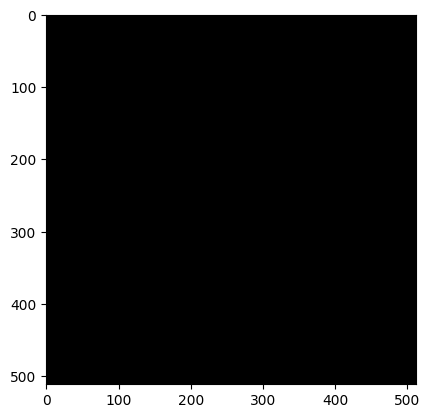

In [28]:
plt.imshow(forgeries(pelican3), cmap = 'gray')
plt.show()